In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
from os.path import join
import os
import random
from functools import partial

In [4]:
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Reshape, concatenate, Activation
from keras.optimizers import Adam
from keras.layers.advanced_activations import ELU
from keras.layers.normalization import BatchNormalization
from keras import backend as K

import tensorflow as tf

In [3]:
K.image_data_format()

'channels_last'

In [9]:
"""
class BatchGenerator:

    @staticmethod
    def to_one_hot(img, n_cls):
        return (np.arange(n_cls) == img[:, :, None]).astype(int)
    
    def __init__(self, txt_filepath, size, n_cls, batch_size):
        self.lines = []
        for line in open(txt_filepath, 'r').readlines():
            line = line.strip()
            if len(line) > 0:
                self.lines.append(line)
        self.size = size
        self.n_cls = n_cls
        self.batch_size = batch_size
        self.i = 0
    
    def get_sample(self):
        if self.i == 0:
            random.shuffle(self.lines)
        orig_filepath, gt_filepath = self.lines[self.i].split()
        orig = cv2.imread(orig_filepath) # 1 and 3 channels swapped "BGR"
        orig = cv2.resize(orig, (size, size)) # 256x256x3
        orig *= 1.0/255
        gt = cv2.imread(gt_filepath)[:, :, 0]
        gt = cv2.resize(gt, (self.size, self.size), cv2.INTER_NEAREST)
        gt = BatchGenerator.to_one_hot(gt, self.n_cls) #  + neutral class
        self.i = (self.i + 1) % len(self.lines)
        return orig, gt
    
    def get_batch(self):
        while True:
            orig_batch = np.zeros((self.batch_size, self.size, self.size, 3))
            gt_batch = np.zeros((self.batch_size, self.size, self.size, self.n_cls))
            for i in range(self.batch_size):
                orig, gt = self.get_sample()
                orig_batch[i] = orig
                gt_batch[i] = gt
            yield orig_batch, gt_batch
            
    def get_size(self):
        return len(self.lines)
"""

In [5]:
train_data_dirpath = "/data2/cityscapes_dataset/leftImg8bit/train"
train_all_fnames = []
all_fnames_list = []
for subfolder_name in os.listdir(train_data_dirpath):
    #print(subfolder_name)
    output_fnames = [join(train_data_dirpath, subfolder_name, fname) for fname in os.listdir(join(train_data_dirpath, subfolder_name))]
    fnames_list = [fname for fname in os.listdir(join(train_data_dirpath, subfolder_name))]
    train_all_fnames+=output_fnames
    all_fnames_list+=fnames_list
#print(train_all_fnames)
#print(all_fnames_list)

In [6]:
val_data_dirpath = "/data2/cityscapes_dataset/leftImg8bit/val"
val_all_fnames = []
#all_fnames_list = []
for subfolder_name in os.listdir(val_data_dirpath):
    #print(subfolder_name)
    output_fnames = [join(val_data_dirpath, subfolder_name, fname) for fname in os.listdir(join(val_data_dirpath, subfolder_name))]
    fnames_list = [fname for fname in os.listdir(join(val_data_dirpath, subfolder_name))]
    val_all_fnames+=output_fnames
    all_fnames_list+=fnames_list
#print(val_all_fnames)

In [7]:
len(train_all_fnames)

2975

In [ ]:
"aachen_000000_000019.png"

In [ ]:
"/data2/cityscapes_dataset/leftImg8bit/train/bochum/bochum_000000_021393_leftImg8bit.png"

In [40]:
with open('/data2/cityscapes_dataset/val_images_labels.txt', 'w') as f:
    for item in train_all_fnames:
        label_name = "/data2/cityscapes_dataset/gtFine_trainId/" + item.split("/")[-1][0:-16] + ".png"
        f.write("%s %s\n" % (item, label_name))

In [20]:
!cat your_file.txt

/data2/cityscapes_dataset/leftImg8bit/train/bochum/bochum_000000_021393_leftImg8bit.png
/data2/cityscapes_dataset/leftImg8bit/train/bochum/bochum_000000_007150_leftImg8bit.png
/data2/cityscapes_dataset/leftImg8bit/train/bochum/bochum_000000_001519_leftImg8bit.png
/data2/cityscapes_dataset/leftImg8bit/train/bochum/bochum_000000_017216_leftImg8bit.png
/data2/cityscapes_dataset/leftImg8bit/train/bochum/bochum_000000_005537_leftImg8bit.png
/data2/cityscapes_dataset/leftImg8bit/train/bochum/bochum_000000_024855_leftImg8bit.png
/data2/cityscapes_dataset/leftImg8bit/train/bochum/bochum_000000_037829_leftImg8bit.png
/data2/cityscapes_dataset/leftImg8bit/train/bochum/bochum_000000_021325_leftImg8bit.png
/data2/cityscapes_dataset/leftImg8bit/train/bochum/bochum_000000_038022_leftImg8bit.png
/data2/cityscapes_dataset/leftImg8bit/train/bochum/bochum_000000_010700_leftImg8bit.png
/data2/cityscapes_dataset/leftImg8bit/train/bochum/bochum_000000_020899_leftImg8bit.png
/data2/cityscapes_dataset/leftIm

### Prepare the training data

In [9]:
"""
data_dirpath = "/data2/cityscapes_dataset" #'/data'
size = 224 # crop size is 224
n_cls = 20 # number of classes is 3
batch_size = 1
train_batch_generator = BatchGenerator(join(data_dirpath, 'train_images_labels.txt'), size, n_cls, batch_size)
val_batch_generator = BatchGenerator(join(data_dirpath, 'val_images_labels.txt'), size, n_cls, batch_size)
"""

'\ndata_dirpath = "/data2/cityscapes_dataset" #\'/data\'\nsize = 224 # crop size is 224\nn_cls = 20 # number of classes is 3\nbatch_size = 1\ntrain_batch_generator = BatchGenerator(join(data_dirpath, \'train_images_labels.txt\'), size, n_cls, batch_size)\nval_batch_generator = BatchGenerator(join(data_dirpath, \'val_images_labels.txt\'), size, n_cls, batch_size)\n'

In [11]:
"""
print('Train size:', train_batch_generator.get_size())
print('Val size:', val_batch_generator.get_size())
"""

Train size: 2975
Val size: 500


In [6]:
from keras.backend.tensorflow_backend import _to_tensor
from keras.backend.common import _EPSILON
"""
def my_bce(target, output):
    epsilon = _to_tensor(_EPSILON, output.dtype.base_dtype)
    output = tf.clip_by_value(output, epsilon, 1. - epsilon)
    
    return -tf.reduce_sum(target[:, :, :, :-1] * tf.log(output),
                           axis=-1)

def my_acc(target, output):
    target = K.cast(target, tf.int32)
    correct_count = K.sum(K.cast(K.equal(K.cast(K.argmax(target, axis=-1), tf.int32), 
                                         K.cast(K.argmax(output, axis=-1), tf.int32)), tf.int32))
    neutral_count = K.sum(K.cast(K.equal(target[:, :, :, -1], K.variable(1, dtype=tf.int32)), tf.int32))
    total_count = K.prod(K.shape(output)[:-1]) - neutral_count
    return tf.cast(correct_count / total_count, tf.float32)
"""

In [10]:
"""
size = 224
def get_unet(size, n_cls):
    inputs = Input((size, size, 3))
    
    conv1 = BatchNormalization()(inputs)
    conv1 = Conv2D(32, (3, 3), padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = ELU()(conv1)
    conv1 = Conv2D(32, (3, 3), padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = ELU()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = ELU()(conv2)
    conv2 = Conv2D(64, (3, 3), padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = ELU()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = ELU()(conv3)
    conv3 = Conv2D(128, (3, 3), padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = ELU()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = ELU()(conv4)
    conv4 = Conv2D(256, (3, 3), padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = ELU()(conv4)
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = ELU()(conv5)
    conv5 = Conv2D(512, (3, 3), padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = ELU()(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = ELU()(conv6)
    conv6 = Conv2D(256, (3, 3), padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = ELU()(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = ELU()(conv7)
    conv7 = Conv2D(128, (3, 3), padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = ELU()(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = ELU()(conv8)
    conv8 = Conv2D(64, (3, 3), padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = ELU()(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = ELU()(conv9)
    conv9 = Conv2D(32, (3, 3), padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = ELU()(conv9)

    conv10 = Conv2D(n_cls, (1, 1), activation='softmax')(conv9) # output is prob.

    model = Model(inputs=inputs, outputs=conv10)
    return model
"""

In [18]:
size = 224
n_label = 20

In [19]:
from keras.models import Sequential
def SegNet():  
    model = Sequential()  
    #encoder
    model.add(Conv2D(64,(3,3),strides=(1,1),input_shape=(size,size,3),padding='same',activation='relu')) # size=224 
    model.add(BatchNormalization())  
    model.add(Conv2D(64,(3,3),strides=(1,1),padding='same',activation='relu'))  
    model.add(BatchNormalization())  
    model.add(MaxPooling2D(pool_size=(2,2)))  
    #(128,128)  
    model.add(Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu'))  
    model.add(BatchNormalization())  
    model.add(Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu'))  
    model.add(BatchNormalization())  
    model.add(MaxPooling2D(pool_size=(2, 2)))  
    #(64,64)  
    model.add(Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu'))  
    model.add(BatchNormalization())  
    model.add(Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu'))  
    model.add(BatchNormalization())  
    model.add(Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu'))  
    model.add(BatchNormalization())  
    model.add(MaxPooling2D(pool_size=(2, 2)))  
    #(32,32)  
    model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu'))  
    model.add(BatchNormalization())  
    model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu'))  
    model.add(BatchNormalization())  
    model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu'))  
    model.add(BatchNormalization())  
    model.add(MaxPooling2D(pool_size=(2, 2)))  
    #(16,16)  
    model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu'))  
    model.add(BatchNormalization())  
    model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu'))  
    model.add(BatchNormalization())  
    model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu'))  
    model.add(BatchNormalization())  
    model.add(MaxPooling2D(pool_size=(2, 2)))  
    #(8,8)  
    #decoder  
    model.add(UpSampling2D(size=(2,2)))  
    #(16,16)  
    model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu'))  
    model.add(BatchNormalization())  
    model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu'))  
    model.add(BatchNormalization())  
    model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu'))  
    model.add(BatchNormalization())  
    model.add(UpSampling2D(size=(2, 2)))  
    #(32,32)  
    model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu'))  
    model.add(BatchNormalization())  
    model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu'))  
    model.add(BatchNormalization())  
    model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu'))  
    model.add(BatchNormalization())  
    model.add(UpSampling2D(size=(2, 2)))  
    #(64,64)  
    model.add(Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu'))  
    model.add(BatchNormalization())  
    model.add(Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu'))  
    model.add(BatchNormalization())  
    model.add(Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu'))  
    model.add(BatchNormalization())  
    model.add(UpSampling2D(size=(2, 2)))  
    #(128,128)  
    model.add(Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu'))  
    model.add(BatchNormalization())  
    model.add(Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu'))  
    model.add(BatchNormalization())  
    model.add(UpSampling2D(size=(2, 2)))  
    #(256,256)  
    model.add(Conv2D(64, (3, 3), strides=(1, 1), input_shape=(size, size,3), padding='same', activation='relu'))  
    model.add(BatchNormalization())  
    model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu'))  
    model.add(BatchNormalization())  
    model.add(Conv2D(n_label, (1, 1), strides=(1, 1), padding='same'))  
    model.add(Reshape((size*size, n_label)))  
    #axis=1和axis=2互换位置，等同于np.swapaxes(layer,1,2)  
    #model.add(Permute((2,1)))  
    model.add(Activation('softmax'))  
    model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])  
    model.summary()  
    return model

In [20]:
#size = 224 # crop size is 224
n_cls = 20 # number of classes is 3

In [21]:
# model = get_unet(224, n_cls)
model = SegNet()
#model.compile(optimizer=Adam(lr=0.01), loss=my_bce)#, metrics=[my_acc])
# model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
batch_normalization_27 (Batc (None, 224, 224, 64)      256       
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
batch_normalization_28 (Batc (None, 224, 224, 64)      256       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 112, 112, 128)     73856     
_________________________________________________________________
batch_normalization_29 (Batc (None, 112, 112, 128)     512       
__________

In [22]:
"""
history = model.fit_generator(train_batch_generator.get_batch(), 
                              steps_per_epoch=train_batch_generator.get_size() // batch_size,
                              epochs=5,
                              validation_data=val_batch_generator.get_batch(),
                              validation_steps=200 // batch_size)
"""

'\nhistory = model.fit_generator(train_batch_generator.get_batch(), \n                              steps_per_epoch=train_batch_generator.get_size() // batch_size,\n                              epochs=5,\n                              validation_data=val_batch_generator.get_batch(),\n                              validation_steps=200 // batch_size)\n'

In [17]:
for i, train_fname in enumerate(train_all_fnames):
    print(i, train_fname)

0 /data2/cityscapes_dataset/leftImg8bit/train/bochum/bochum_000000_021393_leftImg8bit.png
1 /data2/cityscapes_dataset/leftImg8bit/train/bochum/bochum_000000_007150_leftImg8bit.png
2 /data2/cityscapes_dataset/leftImg8bit/train/bochum/bochum_000000_001519_leftImg8bit.png
3 /data2/cityscapes_dataset/leftImg8bit/train/bochum/bochum_000000_017216_leftImg8bit.png
4 /data2/cityscapes_dataset/leftImg8bit/train/bochum/bochum_000000_005537_leftImg8bit.png
5 /data2/cityscapes_dataset/leftImg8bit/train/bochum/bochum_000000_024855_leftImg8bit.png
6 /data2/cityscapes_dataset/leftImg8bit/train/bochum/bochum_000000_037829_leftImg8bit.png
7 /data2/cityscapes_dataset/leftImg8bit/train/bochum/bochum_000000_021325_leftImg8bit.png
8 /data2/cityscapes_dataset/leftImg8bit/train/bochum/bochum_000000_038022_leftImg8bit.png
9 /data2/cityscapes_dataset/leftImg8bit/train/bochum/bochum_000000_010700_leftImg8bit.png
10 /data2/cityscapes_dataset/leftImg8bit/train/bochum/bochum_000000_020899_leftImg8bit.png
11 /data2

935 /data2/cityscapes_dataset/leftImg8bit/train/monchengladbach/monchengladbach_000000_001068_leftImg8bit.png
936 /data2/cityscapes_dataset/leftImg8bit/train/monchengladbach/monchengladbach_000000_026305_leftImg8bit.png
937 /data2/cityscapes_dataset/leftImg8bit/train/monchengladbach/monchengladbach_000000_015685_leftImg8bit.png
938 /data2/cityscapes_dataset/leftImg8bit/train/monchengladbach/monchengladbach_000000_033454_leftImg8bit.png
939 /data2/cityscapes_dataset/leftImg8bit/train/monchengladbach/monchengladbach_000000_034302_leftImg8bit.png
940 /data2/cityscapes_dataset/leftImg8bit/train/monchengladbach/monchengladbach_000000_030010_leftImg8bit.png
941 /data2/cityscapes_dataset/leftImg8bit/train/monchengladbach/monchengladbach_000000_010505_leftImg8bit.png
942 /data2/cityscapes_dataset/leftImg8bit/train/monchengladbach/monchengladbach_000000_012672_leftImg8bit.png
943 /data2/cityscapes_dataset/leftImg8bit/train/monchengladbach/monchengladbach_000000_018575_leftImg8bit.png
944 /data2

1935 /data2/cityscapes_dataset/leftImg8bit/train/hanover/hanover_000000_053604_leftImg8bit.png
1936 /data2/cityscapes_dataset/leftImg8bit/train/hanover/hanover_000000_048379_leftImg8bit.png
1937 /data2/cityscapes_dataset/leftImg8bit/train/hanover/hanover_000000_027766_leftImg8bit.png
1938 /data2/cityscapes_dataset/leftImg8bit/train/hanover/hanover_000000_049465_leftImg8bit.png
1939 /data2/cityscapes_dataset/leftImg8bit/train/hanover/hanover_000000_039021_leftImg8bit.png
1940 /data2/cityscapes_dataset/leftImg8bit/train/hanover/hanover_000000_040294_leftImg8bit.png
1941 /data2/cityscapes_dataset/leftImg8bit/train/hanover/hanover_000000_034347_leftImg8bit.png
1942 /data2/cityscapes_dataset/leftImg8bit/train/hanover/hanover_000000_037516_leftImg8bit.png
1943 /data2/cityscapes_dataset/leftImg8bit/train/hanover/hanover_000000_016038_leftImg8bit.png
1944 /data2/cityscapes_dataset/leftImg8bit/train/hanover/hanover_000000_024719_leftImg8bit.png
1945 /data2/cityscapes_dataset/leftImg8bit/train/h

2935 /data2/cityscapes_dataset/leftImg8bit/train/tubingen/tubingen_000000_000019_leftImg8bit.png
2936 /data2/cityscapes_dataset/leftImg8bit/train/tubingen/tubingen_000002_000019_leftImg8bit.png
2937 /data2/cityscapes_dataset/leftImg8bit/train/tubingen/tubingen_000037_000019_leftImg8bit.png
2938 /data2/cityscapes_dataset/leftImg8bit/train/tubingen/tubingen_000137_000019_leftImg8bit.png
2939 /data2/cityscapes_dataset/leftImg8bit/train/tubingen/tubingen_000059_000019_leftImg8bit.png
2940 /data2/cityscapes_dataset/leftImg8bit/train/tubingen/tubingen_000117_000019_leftImg8bit.png
2941 /data2/cityscapes_dataset/leftImg8bit/train/tubingen/tubingen_000133_000019_leftImg8bit.png
2942 /data2/cityscapes_dataset/leftImg8bit/train/tubingen/tubingen_000094_000019_leftImg8bit.png
2943 /data2/cityscapes_dataset/leftImg8bit/train/tubingen/tubingen_000009_000019_leftImg8bit.png
2944 /data2/cityscapes_dataset/leftImg8bit/train/tubingen/tubingen_000143_000019_leftImg8bit.png
2945 /data2/cityscapes_dataset

In [23]:
img_w, img_h = size, size
#img_w, img_h = 2048, 1024
n_label=20
batch_size=1

In [24]:
"""
def get_train_val(val_rate = 0.25):
    train_url = []    
    train_set = []
    val_set  = []
    for pic in os.listdir(filepath + 'src'):
        train_url.append(pic)
    random.shuffle(train_url)
    total_num = len(train_url)
    val_num = int(val_rate * total_num)
    for i in range(len(train_url)):
        if i < val_num:
            val_set.append(train_url[i]) 
        else:
            train_set.append(train_url[i])
    return train_set,val_set
"""  
from keras.preprocessing import image
from keras.utils import to_categorical
# data for training  
def generateTrainData(batch_size):  
    #print 'generateData...'
    while True:  
        train_data = []  
        train_label = []  
        batch = 0  
        #for i in (range(len(data))): 
        for i, train_fname in enumerate(train_all_fnames):
            #url = data[i]
            batch += 1 
            #print (filepath + 'src/' + url)
            #img = load_img(filepath + 'src/' + url, target_size=(img_w, img_h))  
            #img = load_img(filepath + 'src/' + url)
            img = image.load_img(train_fname, target_size=(img_w, img_h,3))
            img = image.img_to_array(img) 
            # print img
            # print img.shape  
            train_data.append(img)  
            #label = load_img(filepath + 'label/' + url, target_size=(img_w, img_h),grayscale=True)
            train_label_name = "/data2/cityscapes_dataset/gtFine_trainId/" + train_fname.split("/")[-1][0:-16] + ".png"
            label = image.load_img(train_label_name, grayscale=True, target_size=(img_w, img_h))
            label = image.img_to_array(label).reshape((img_w * img_h,)) # reshape to 1-D vector  
            # print label.shape  
            train_label.append(label)  
            if batch % batch_size==0: 
                #print 'get enough bacth!\n'
                train_data = np.array(train_data)  
                train_label = np.array(train_label).flatten()  
                #train_label = labelencoder.transform(train_label)  
                train_label = to_categorical(train_label, num_classes=n_label)  
                train_label = train_label.reshape((batch_size, img_w * img_h, n_label))  
                yield (train_data,train_label)  
                train_data = []  
                train_label = []  
                batch = 0

In [25]:
def generateValData(batch_size):  
    #print 'generateData...'
    while True:  
        val_data = []  
        val_label = []  
        batch = 0  
        #for i in (range(len(data))): 
        for i, val_fname in enumerate(val_all_fnames):
            #url = data[i]
            batch += 1 
            #print (filepath + 'src/' + url)
            #img = load_img(filepath + 'src/' + url, target_size=(img_w, img_h))  
            #img = load_img(filepath + 'src/' + url)
            img = image.load_img(val_fname, target_size=(img_w, img_h,3))
            img = image.img_to_array(img) 
            # print img
            # print img.shape  
            val_data.append(img)  
            #label = load_img(filepath + 'label/' + url, target_size=(img_w, img_h),grayscale=True)
            val_label_name = "/data2/cityscapes_dataset/gtFine_trainId/" + val_fname.split("/")[-1][0:-16] + ".png"
            label = image.load_img(val_label_name, grayscale=True, target_size=(img_w, img_h))
            label = image.img_to_array(label).reshape((img_w * img_h,)) # reshape to 1-D vector  
            # print label.shape  
            val_label.append(label)  
            if batch % batch_size==0: 
                #print 'get enough bacth!\n'
                val_data = np.array(val_data)  
                val_label = np.array(val_label).flatten()  
                #val_label = labelencoder.transform(val_label)  
                val_label = to_categorical(val_label, num_classes=n_label)  
                val_label = val_label.reshape((batch_size, img_w * img_h, n_label))  
                yield (val_data,val_label)  
                val_data = []  
                val_label = []  
                batch = 0

In [26]:
EPOCHS = 3
BS = 1

history = model.fit_generator(generator=generateTrainData(BS),steps_per_epoch=2975,epochs=EPOCHS,verbose=1,  
                validation_data=generateValData(BS),validation_steps=500)

Epoch 1/3
2975/2975 [==============================] - 514s - loss: 0.9845 - acc: 0.7089 - val_loss: 1.4181 - val_acc: 0.5972
Epoch 2/3
2975/2975 [==============================] - 453s - loss: 0.7620 - acc: 0.7795 - val_loss: 1.2944 - val_acc: 0.6501
Epoch 3/3
2975/2975 [==============================] - 455s - loss: 0.6671 - acc: 0.8063 - val_loss: 1.0802 - val_acc: 0.7007


In [ ]:
"""
history = model.fit_generator(train_batch_generator.get_batch(), 
                              steps_per_epoch=train_batch_generator.get_size() // batch_size,
                              epochs=5,
                              validation_data=val_batch_generator.get_batch(),
                              validation_steps=200 // batch_size)
"""

In [27]:
# save model
model.save('./models/segnet_r224_e3.h5')

In [28]:
test_fname = "/data4/cityscapes_dataset/leftImg8bit/test/berlin/berlin_000000_000019_leftImg8bit.png"
test_img = image.load_img(test_fname, target_size=(img_w, img_h,3))
test_img = image.img_to_array(test_img)
test_img = np.expand_dims(test_img, axis=0)


ValueError: Error when checking : expected conv2d_27_input to have 4 dimensions, but got array with shape (224, 224, 3)

In [30]:
np.expand_dims(test_img, axis=0).shape

(1, 224, 224, 3)

In [32]:
preds = model.predict(np.expand_dims(test_img, axis=0) )
preds.shape

(1, 50176, 20)

In [37]:
preds_view = np.squeeze(preds, axis=0)
preds_view.shape

(50176, 20)

In [42]:
preds_view2 = np.reshape(np.argmax(preds_view, axis=1), (224,224))

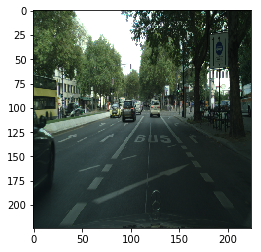

In [46]:
plt.imshow(image.array_to_img(test_img))

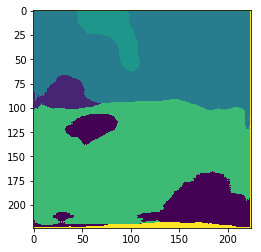

In [44]:
plt.imshow(preds_view2)

In [34]:
preds_new.shape

(1, 224, 224, 20)